# some stations are climatologically different with nearby stations / regression / models. We can call them as toxic stations. We don't know whether they are wrong or affected by some complex natural factors (ocean currents etc). However, in scarecely gauged regions, those station will cause very large effect on interpolated / bias-corrected estimates, which are undesirable because the impact scope of natural factors should not be so large. Therefore, we need to identify those stations to avoid unrealistic estimates. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
var='prcp'
file0 = '/Users/localuser/Research/EMDNA/stndata_whole.npz'
file1 = '/Users/localuser/Research/EMDNA/regression/daily_regression_stn.npz'
file2 = '/Users/localuser/Research/EMDNA/downscale/ERA5_downto_stn_nearest.npz'
filenear = '/Users/localuser/Research/EMDNA/regression/weight_nearstn.npz'

d=np.load(file0)
dstn=d[var+'_stn']
stn_lle=d['stn_lle']
d=np.load(file1)
dreg=d[var]
d=np.load(file2)
drea=d[var+'_readown']

d=np.load(filenear)
if var == 'prcp':
    nearloc = d['near_stn_prcpLoc']
else:
    nearloc = d['near_stn_tempLoc']

In [88]:
from auxiliary import metric
nstn,ntimes=np.shape(dstn)
dstnm=np.nanmean(dstn,axis=1)
dregm=np.nanmean(dreg,axis=1)
dream=np.nanmean(drea,axis=1)
diff=np.nan*np.zeros([nstn,2])
ratio=np.nan*np.zeros([nstn,2])
diff[:,0] = dstnm - dregm
diff[:,1] = dstnm - dream
ratio[:,0] = np.abs(dstnm) / np.abs(dregm)
ratio[:,1] = np.abs(dstnm) / np.abs(dream)

met_rea=np.nan*np.zeros([nstn,4])
met_reg=np.nan*np.zeros([nstn,4])
for i in range(nstn):
    if np.isnan(dstn[i,0]):
        continue
    met_rea[i]=metric(dstn[i],drea[i])
    met_reg[i]=metric(dstn[i],dreg[i])
    
ratio_near = np.nan * np.zeros([nstn,2])
diff_near = np.nan * np.zeros([nstn,2])
for i in range(nstn):
    if np.isnan(dstnm[i]):
        continue
    zz=nearloc[i,0:10]
    ratio_near[i,0]=abs(dstnm[i]/max(dstnm[zz]))
    ratio_near[i,1]=abs(dstnm[i]/np.mean(dstnm[zz]))
    diff_near[i,0]=dstnm[i] - max(dstnm[zz])
    diff_near[i,1]=dstnm[i] - np.mean(dstnm[zz])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


# Identify stations with problems

## Method-1: calculate difference betweem station and regression data
This is the best because lat/lon/ele/slope are all considered, while the other method cannot consider

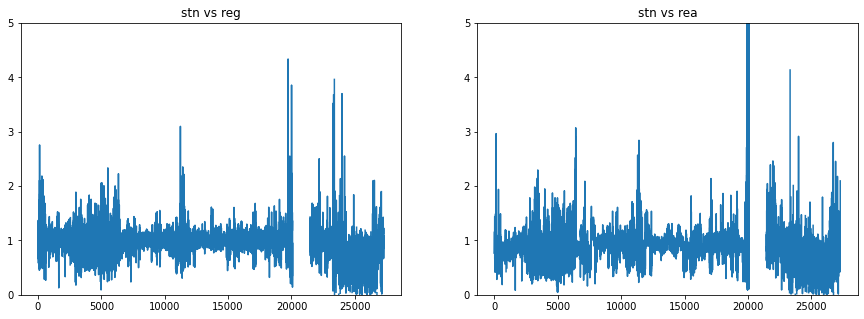

In [127]:
plt.figure(figsize=[15,5])
titles=['stn vs reg','stn vs rea']
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.plot(ratio[:,i])
    plt.title(titles[i])
    plt.ylim([0,5])

In [179]:
p1=np.nanpercentile(ratio[:,0], 99.9)
p2=np.nanpercentile(ratio_near[:,1], 99.9)
p3=np.nanpercentile(ratio[:,0],1)
p4=np.nanpercentile(ratio_near[:,1],1)

# ind_toxic1=np.where(((ratio[:,0]<p3) & (ratio_near[:,1]<p4)))[0]
ind_toxic1=np.where(((ratio[:,0]>p1) & (ratio_near[:,1]>p2)) | ((ratio[:,0]<p3) & (ratio_near[:,1]<p4)))[0]
print(p1,p2,p3,p4)
print(np.shape(ind_toxic1))
print(ind_toxic1)

2.114395822763459 2.705828075647391 0.5045408999919891 0.4864844524860382
(381,)
[  135   507   510   614  1647  2155  2958  3001  3002  3003  3007  3021
  3047  3070  3094  3120  3144  3247  3421  3431  3706  4068  4406  4531
  4908  4923  4930  4963  4971  4986  5074  5083  5118  5124  5139  5187
  5204  5224  5236  5237  5263  5489  5585  5613  5727  5853  6075  6144
  7336  7940 10868 10938 11379 11386 11476 14959 15551 18261 19732 19744
 19891 19909 19959 19980 19991 20000 20001 20005 20013 20041 20078 22353
 22648 22654 22690 22842 23248 23249 23252 23257 23262 23265 23269 23272
 23273 23274 23279 23280 23284 23286 23290 23291 23293 23294 23299 23302
 23306 23310 23312 23315 23316 23317 23328 23334 23335 23341 23343 23350
 23351 23352 23361 23362 23368 23376 23381 23384 23389 23390 23393 23398
 23403 23407 23413 23419 23422 23462 23507 23517 23652 23726 23727 23769
 23801 23803 23821 23841 23842 23861 23875 23882 23894 23896 23897 23952
 23953 23980 23983 23989 24000 24100 24180 

In [180]:
len(ind_toxic1)/np.sum(~np.isnan(dstnm))

0.015499145716377838

In [116]:
    itar=ind_toxic1[0]
    inear=nearloc[itar]
    inear=inear[inear>-1]
    print('tar stn',dstnm[itar])
    print('tar reg',dregm[itar])
    print('near stn',dstnm[inear])

tar stn 1.0510665
tar reg 3.6872947
near stn [ 1.1442677  1.4728092  1.0900284  1.102252   1.0754393  1.2188928
  2.0128834  5.0224867 11.89433    5.514683  10.886056   7.7163224
  4.442742   8.110466   3.088948   6.0055666  2.0963304  4.153674
  6.44661    4.3870277  4.2834687  4.5499234  1.590945   3.901799
  4.516624   4.7368326  4.2855406  4.7851872  5.0073066  9.328395 ]


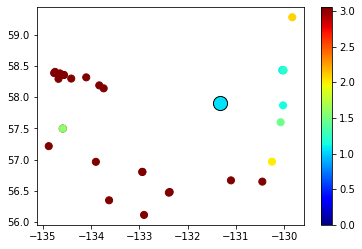

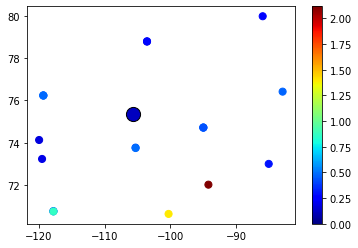

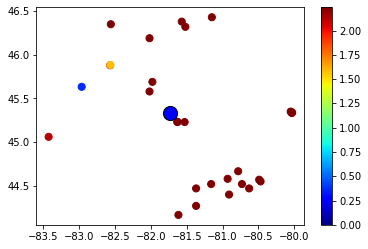

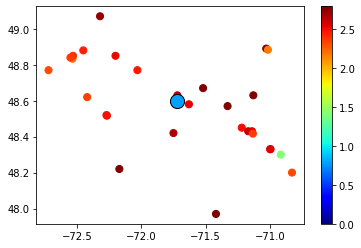

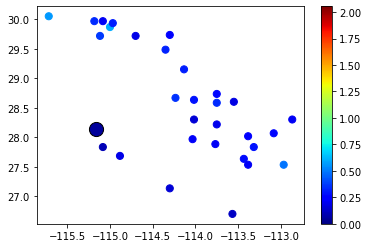

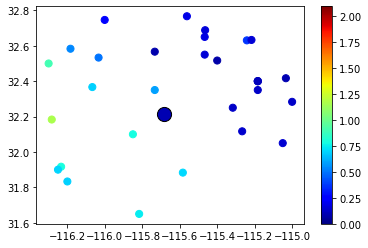

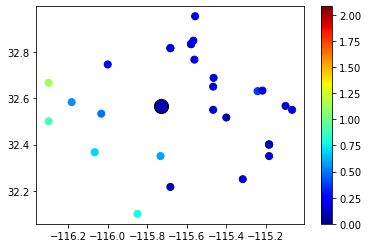

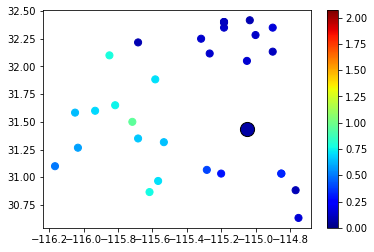

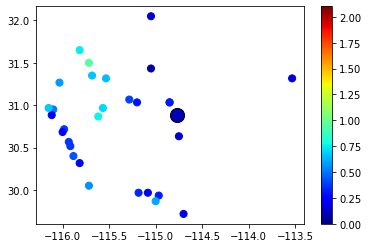

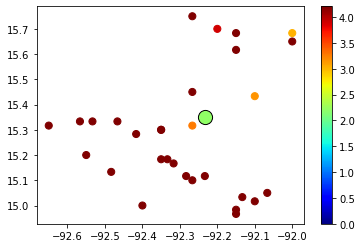

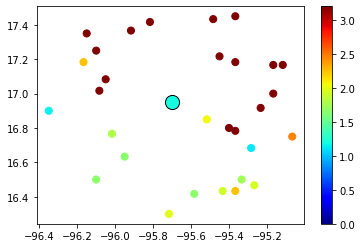

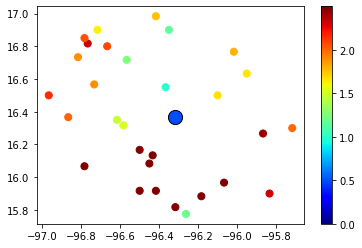

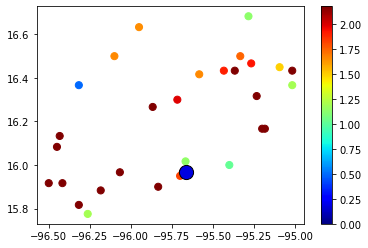

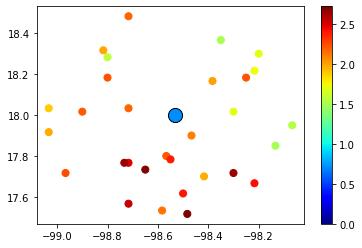

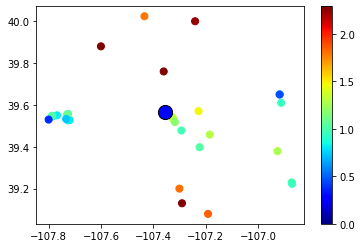

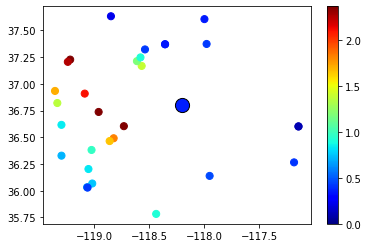

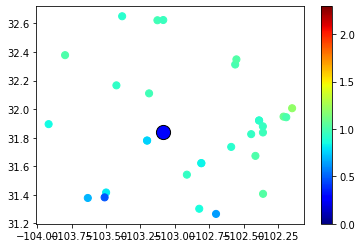

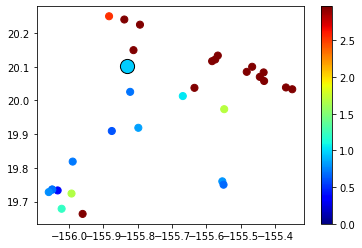

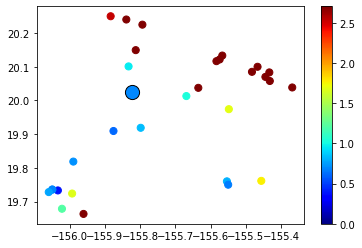

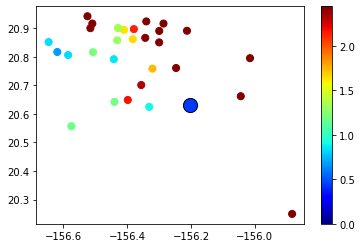

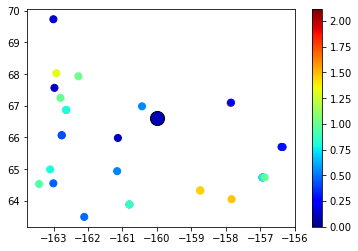

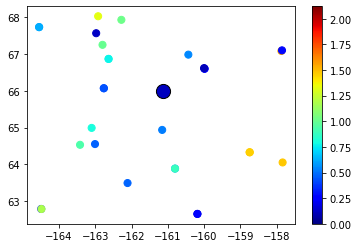

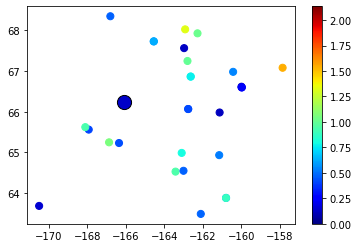

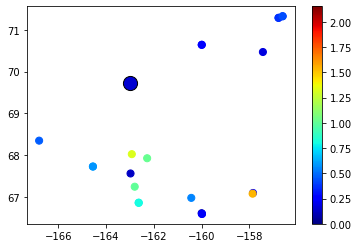

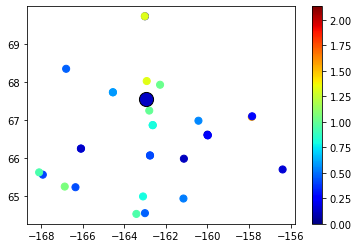

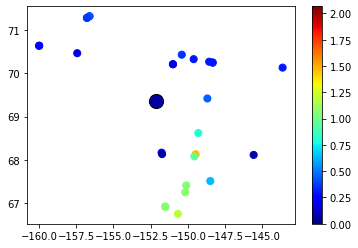

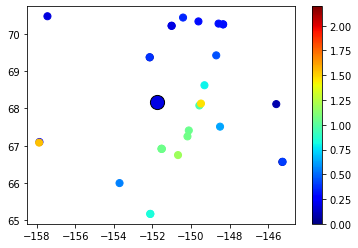

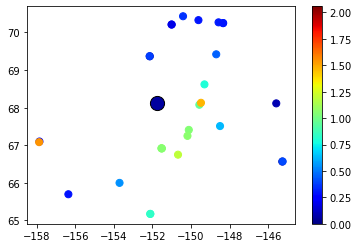

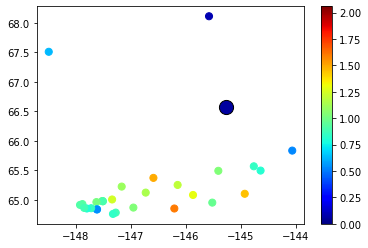

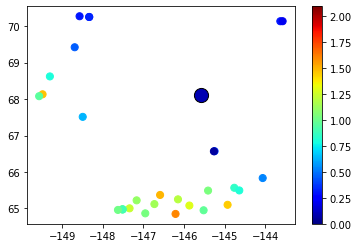

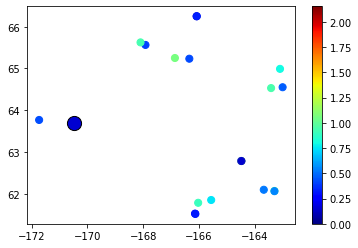

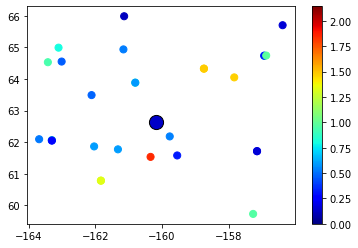

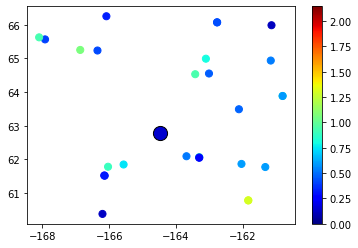

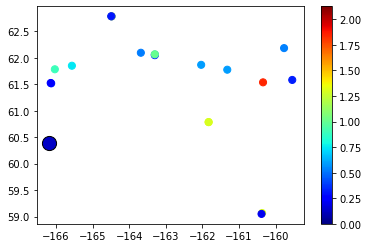

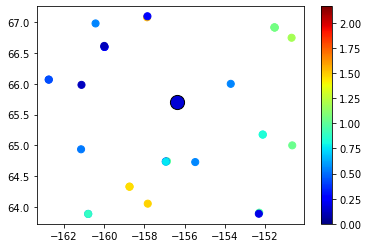

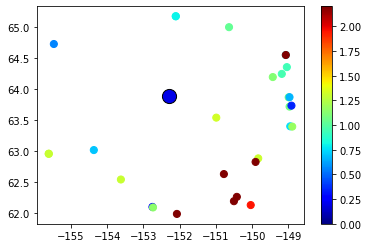

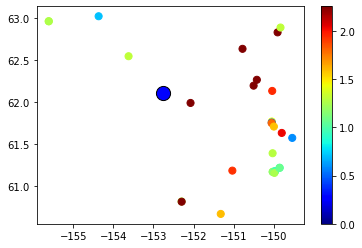

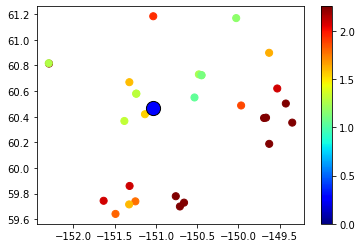

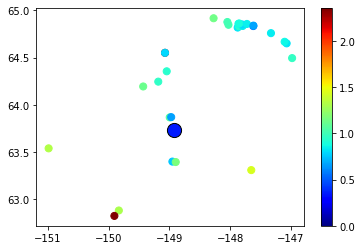

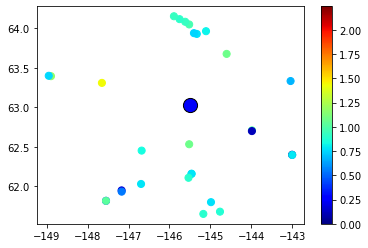

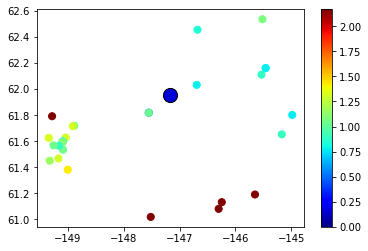

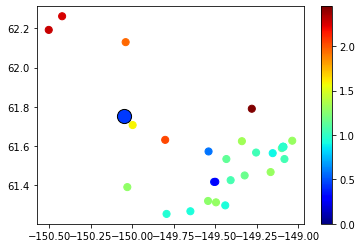

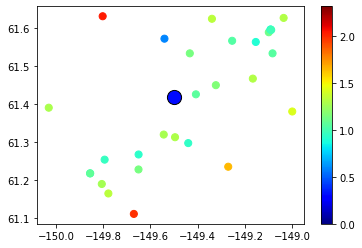

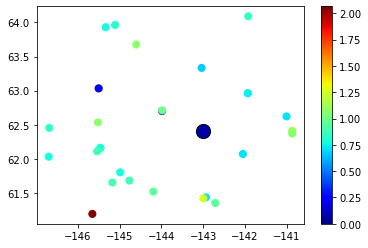

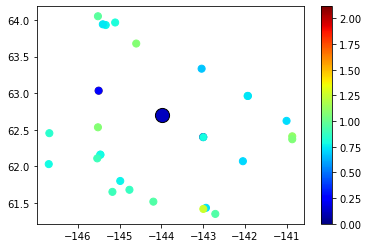

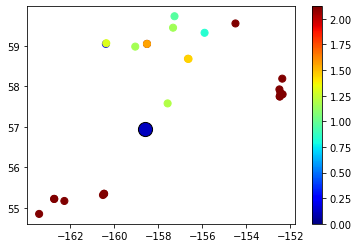

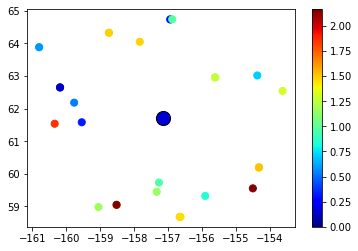

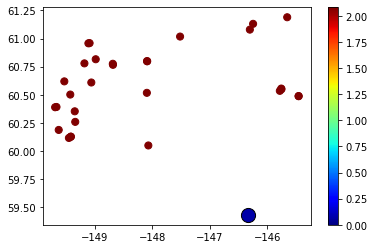

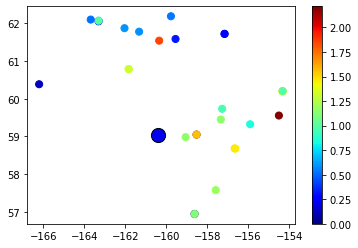

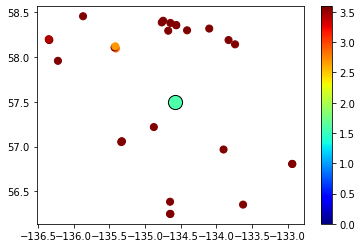

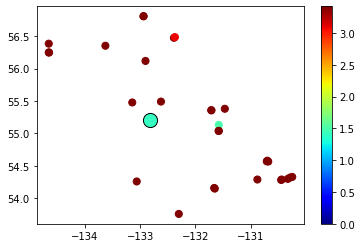

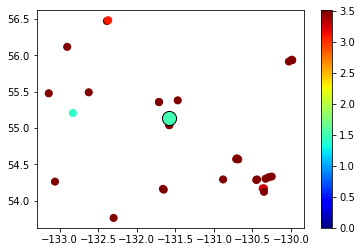

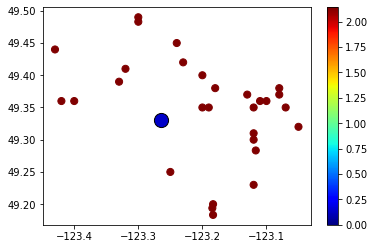

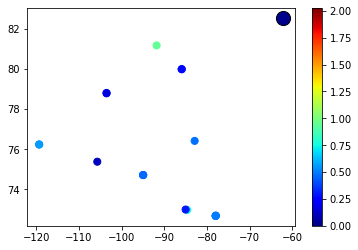

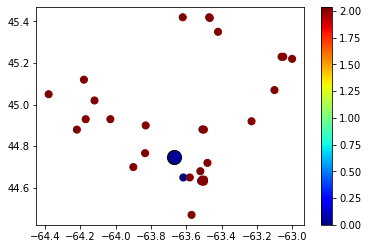

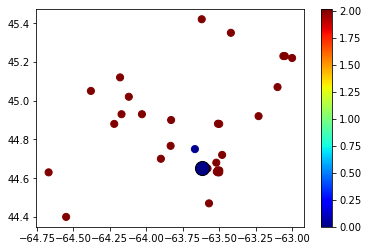

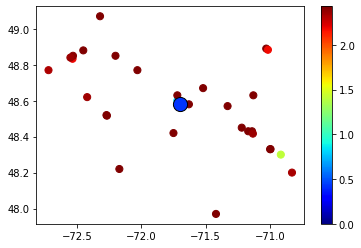

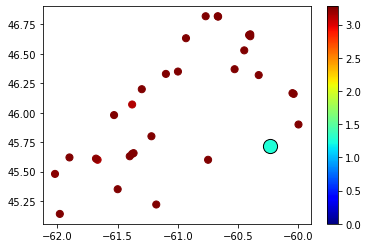

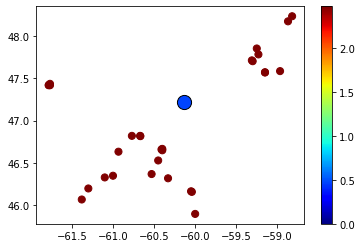

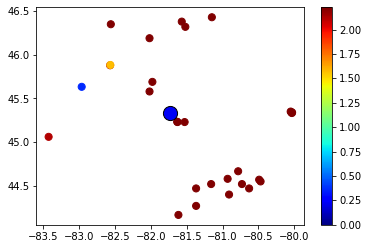

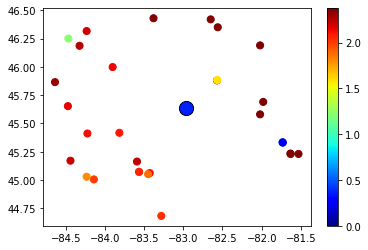

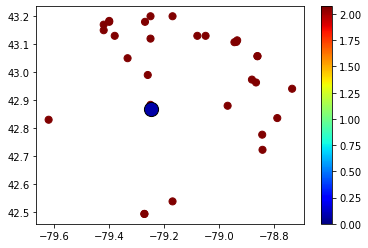

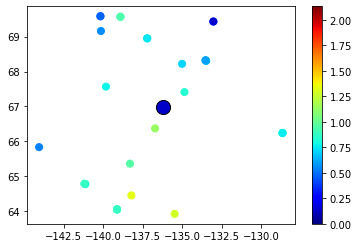

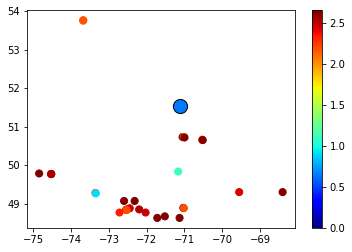

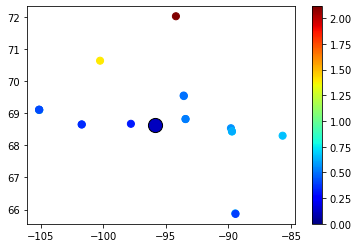

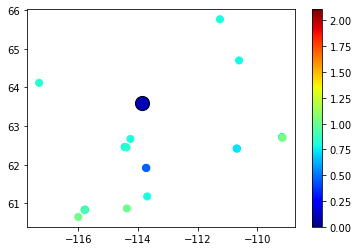

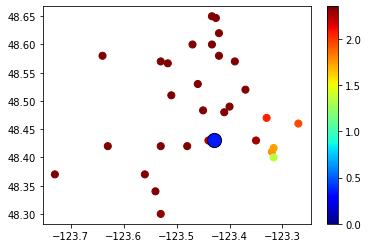

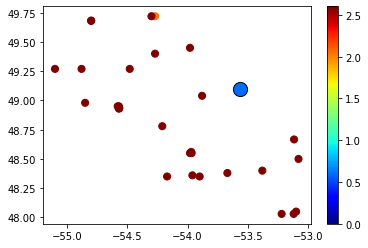

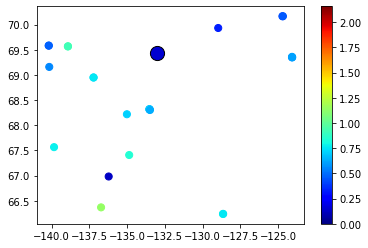

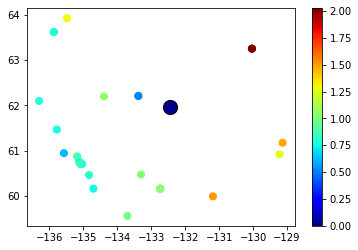

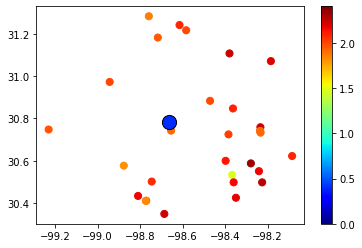

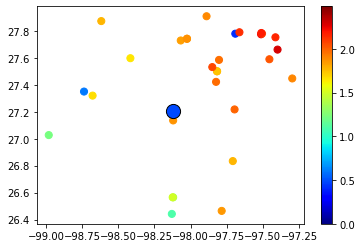

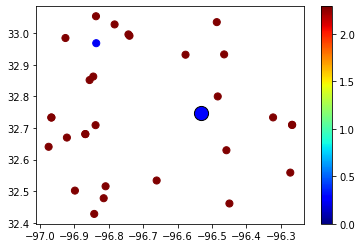

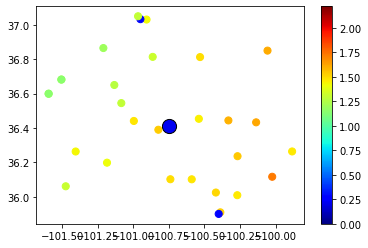

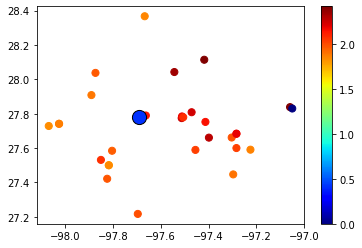

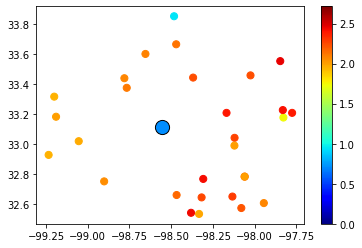

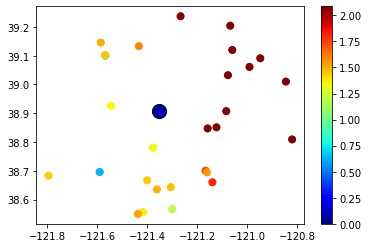

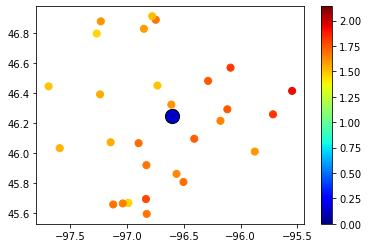

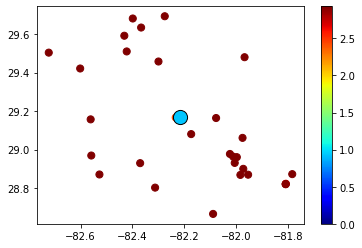

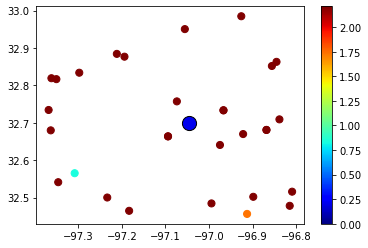

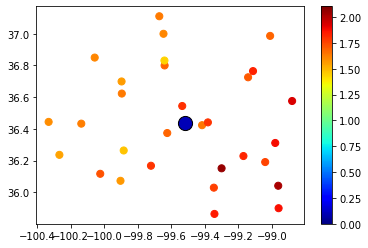

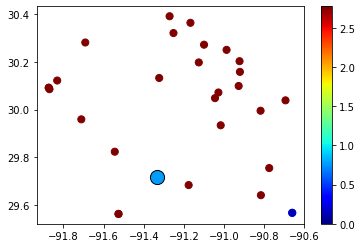

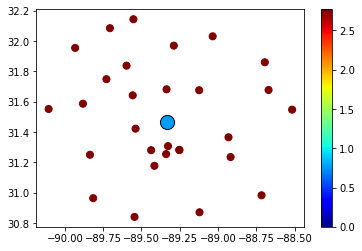

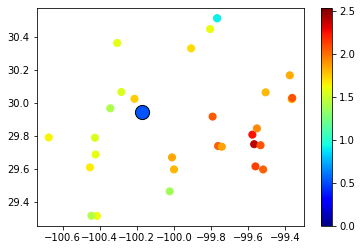

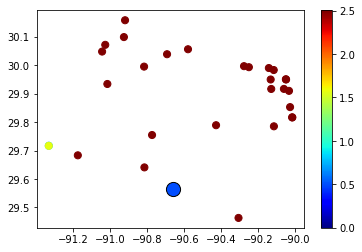

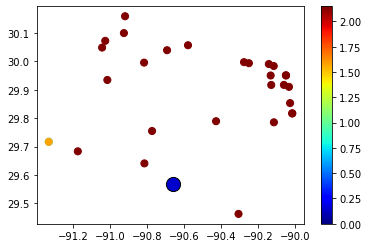

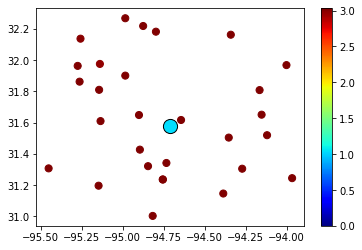

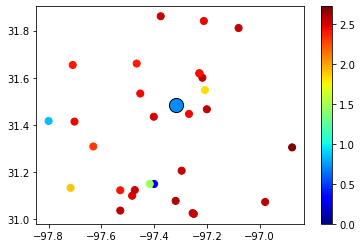

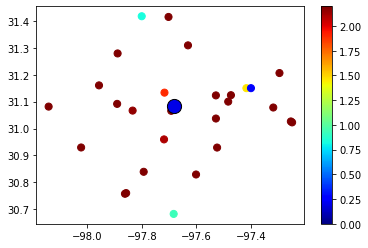

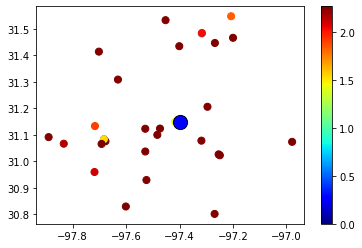

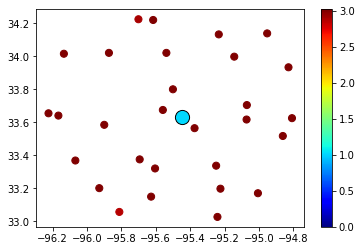

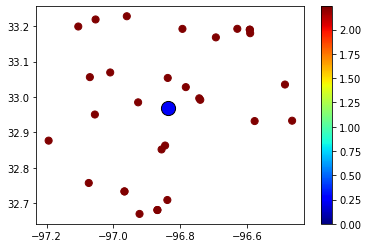

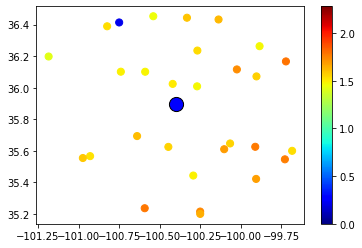

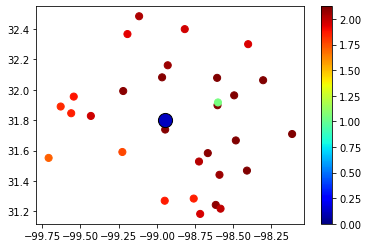

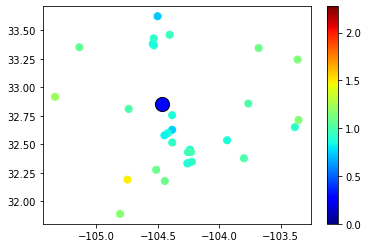

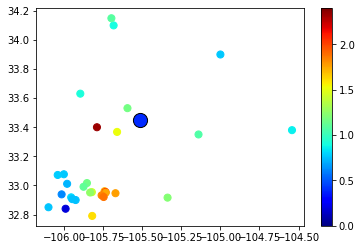

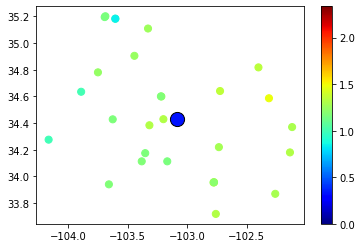

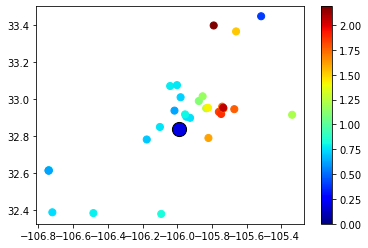

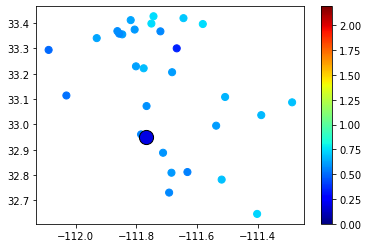

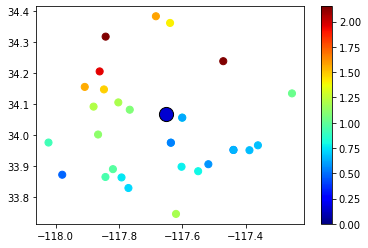

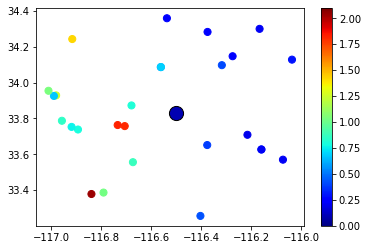

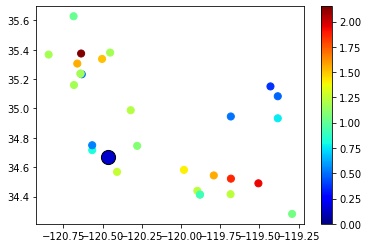

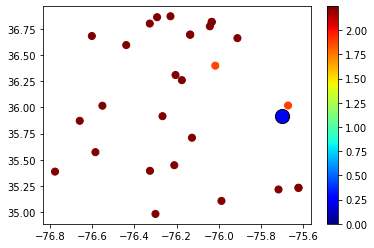

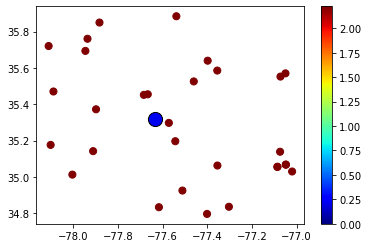

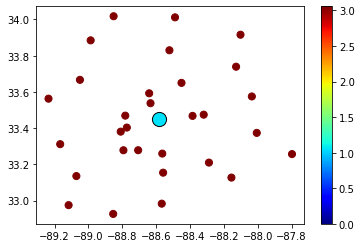

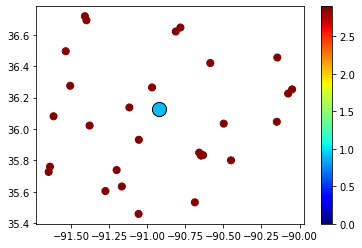

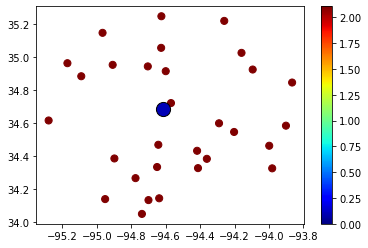

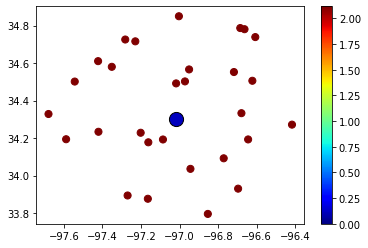

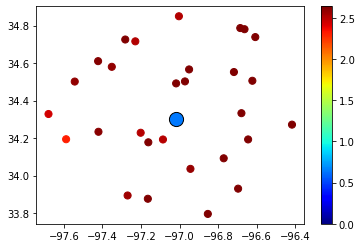

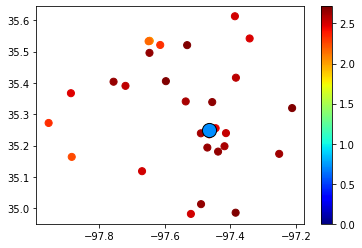

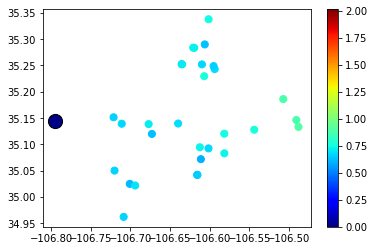

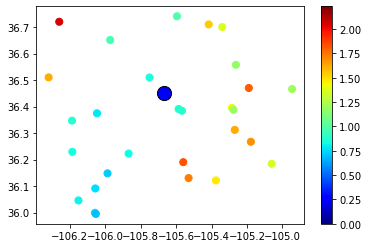

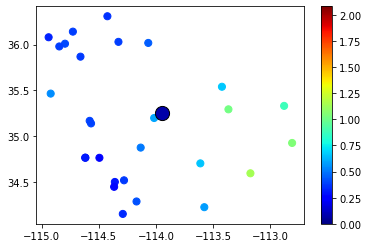

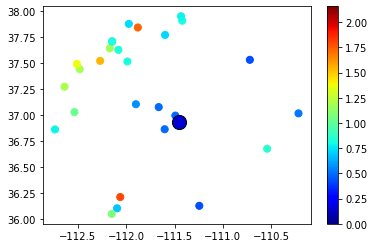

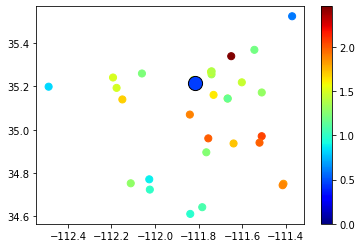

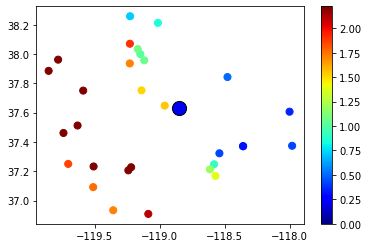

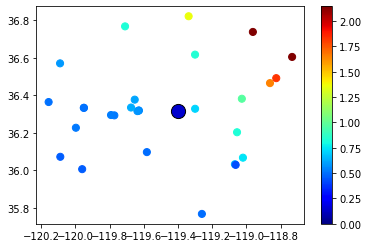

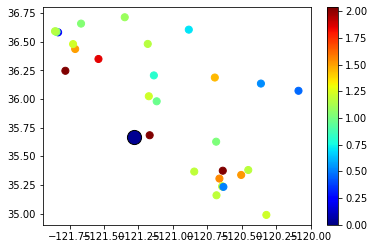

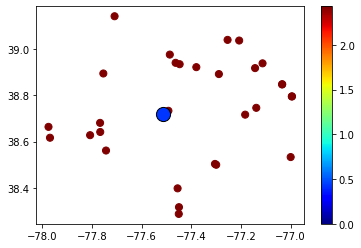

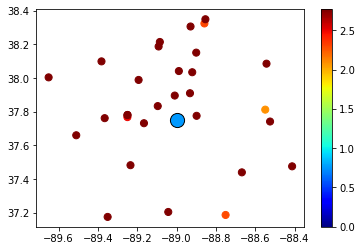

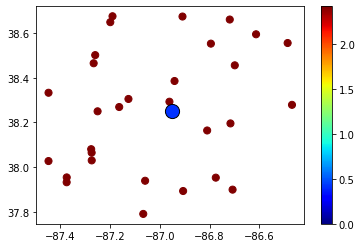

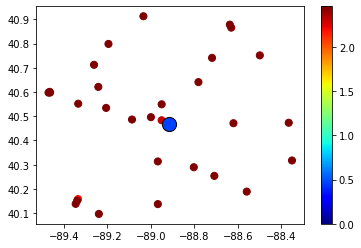

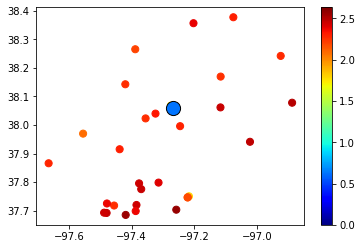

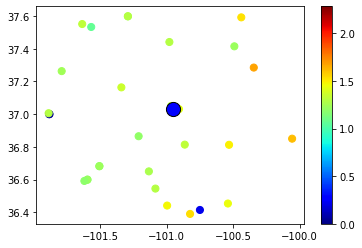

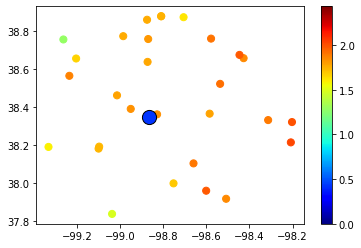

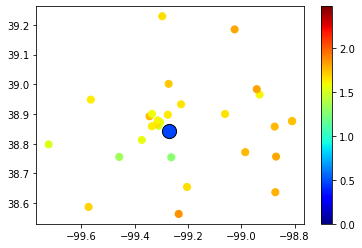

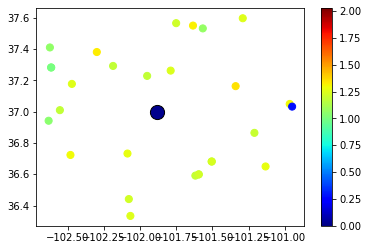

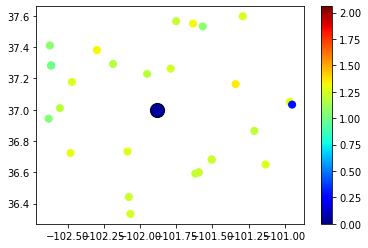

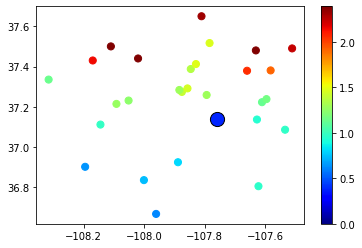

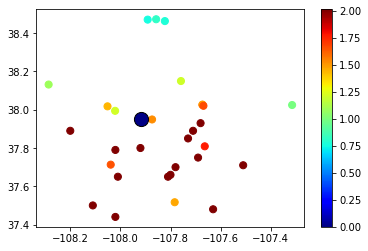

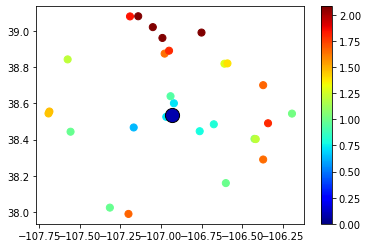

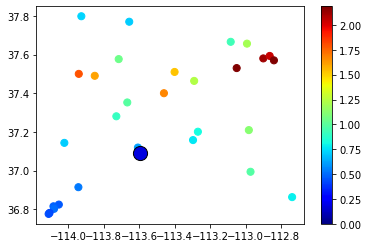

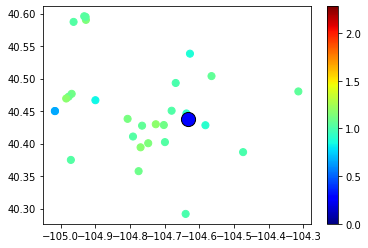

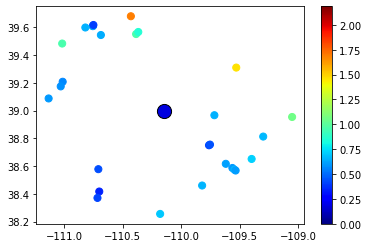

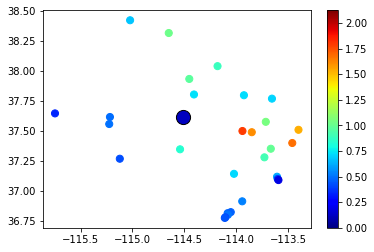

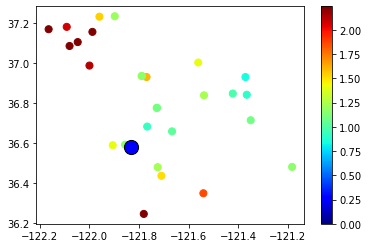

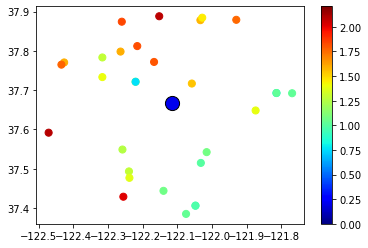

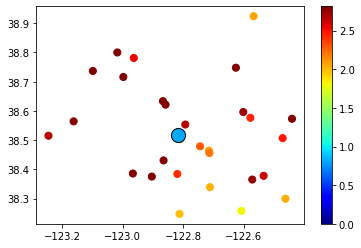

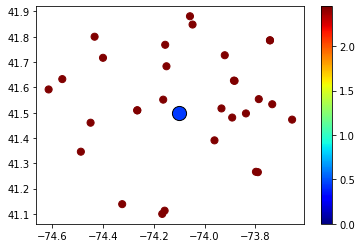

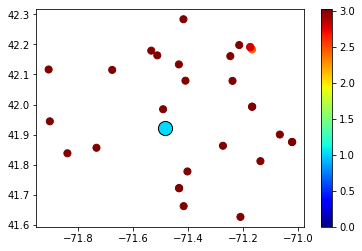

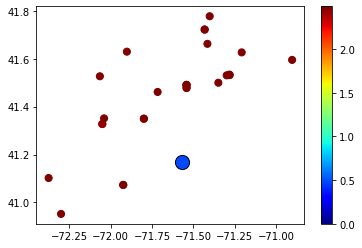

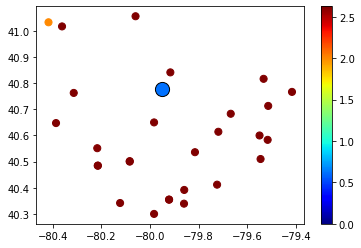

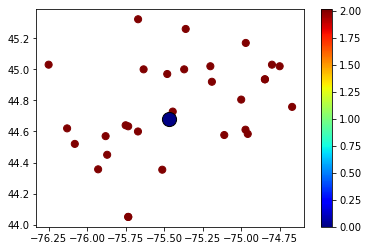

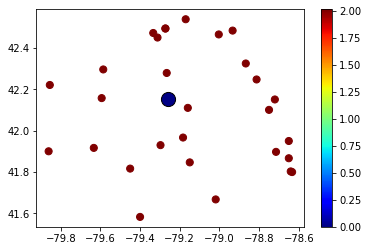

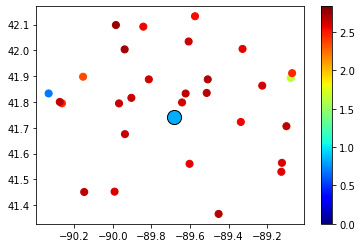

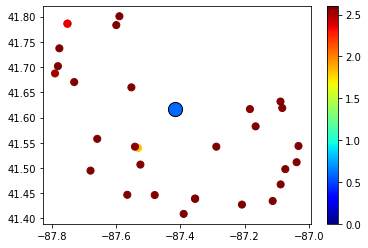

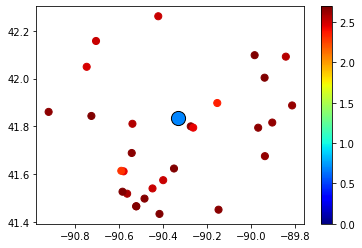

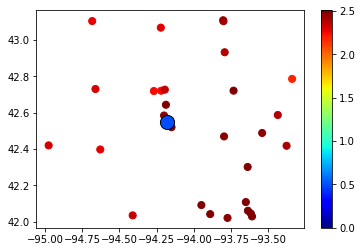

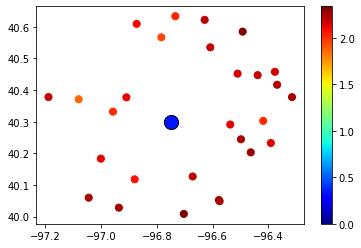

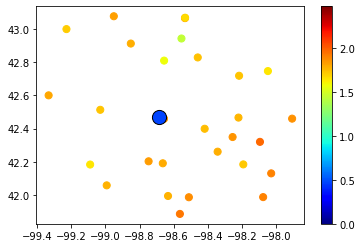

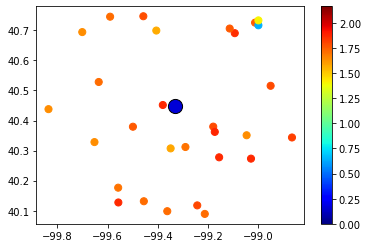

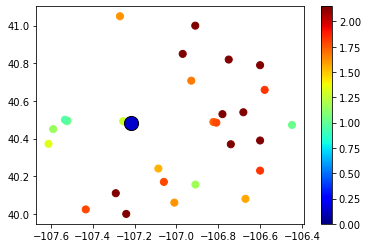

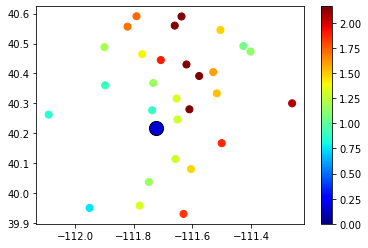

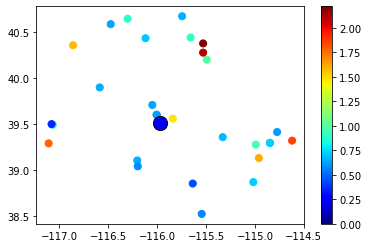

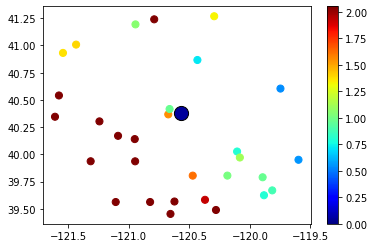

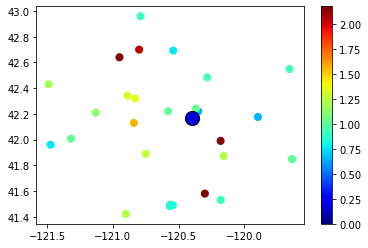

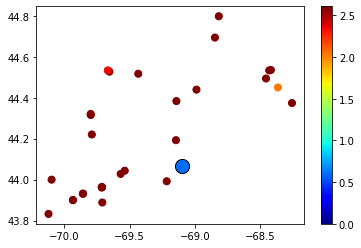

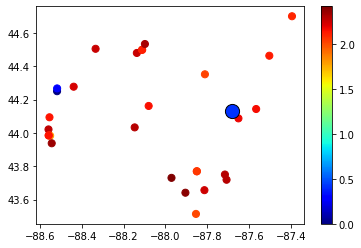

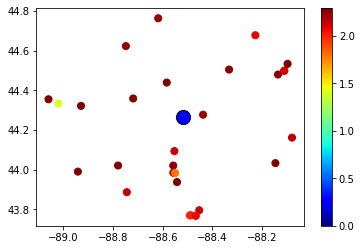

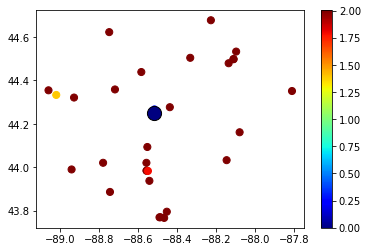

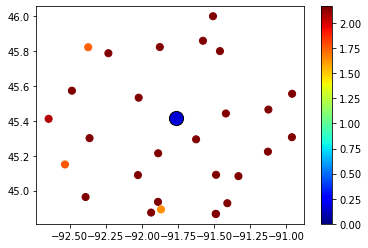

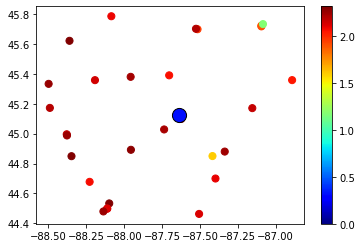

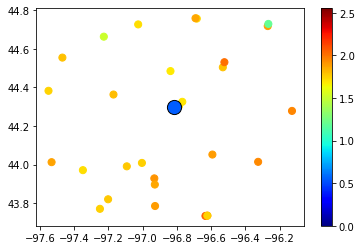

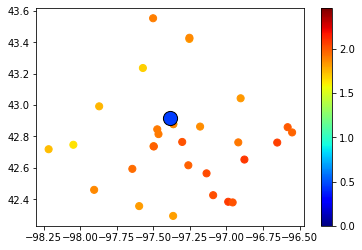

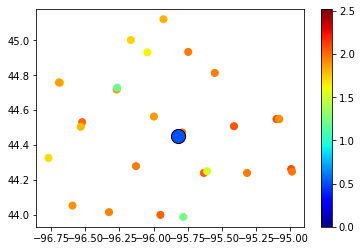

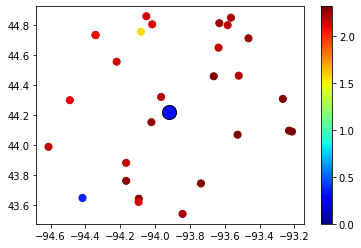

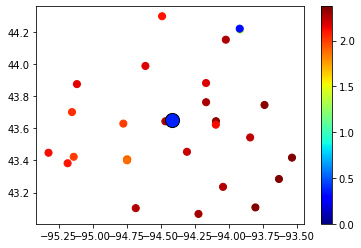

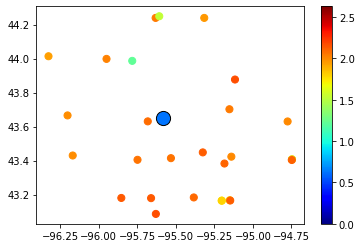

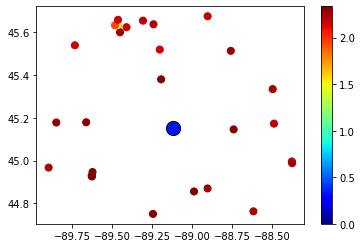

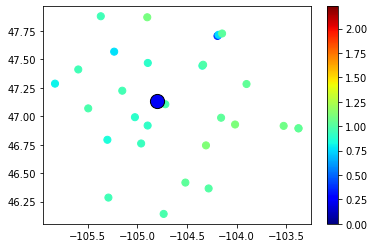

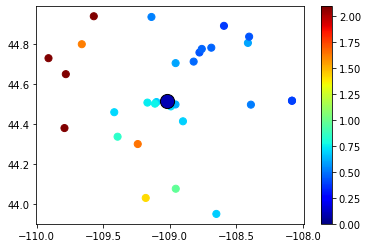

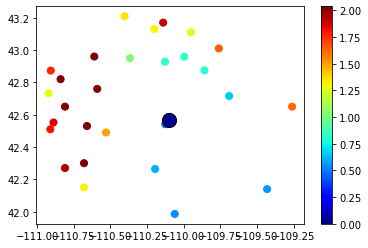

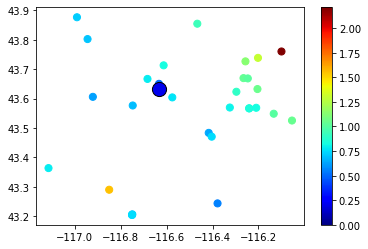

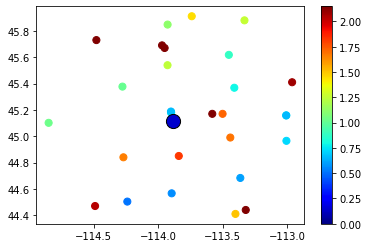

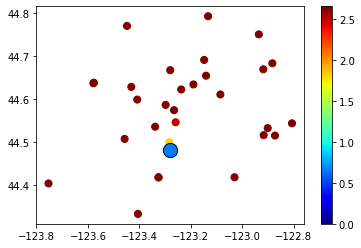

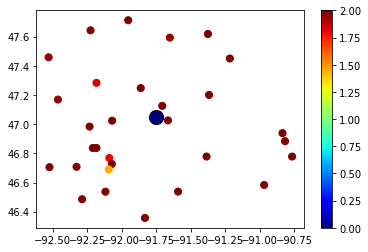

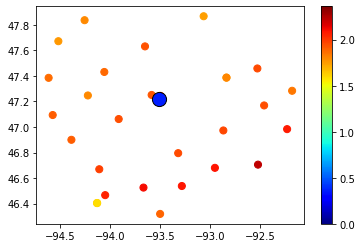

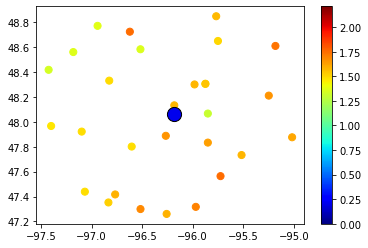

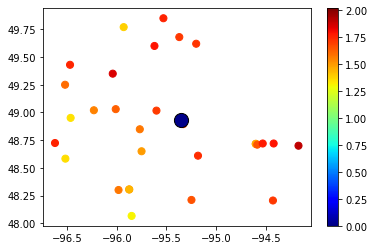

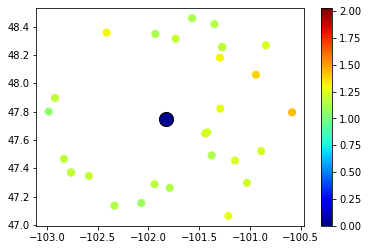

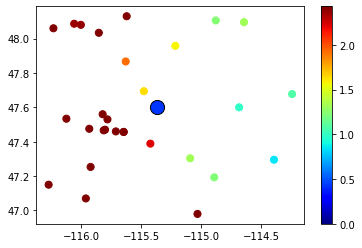

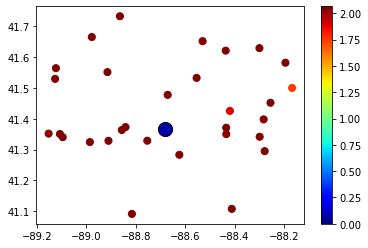

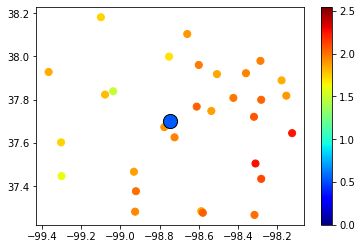

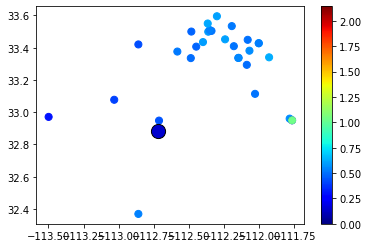

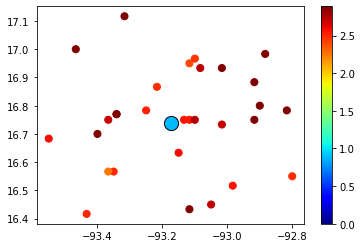

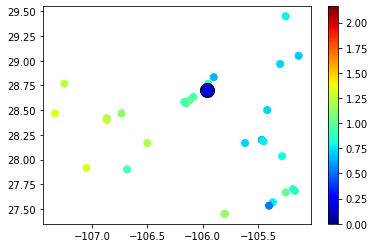

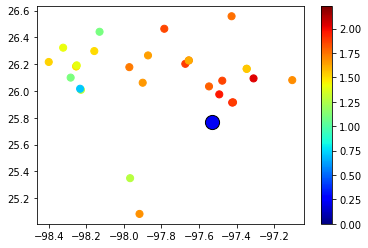

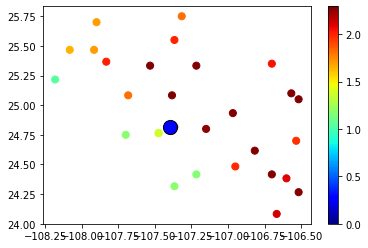

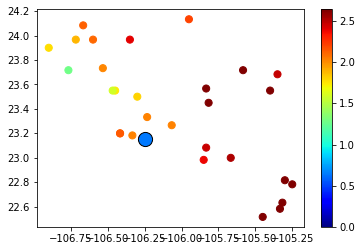

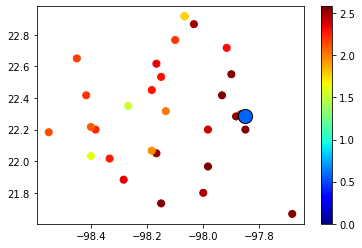

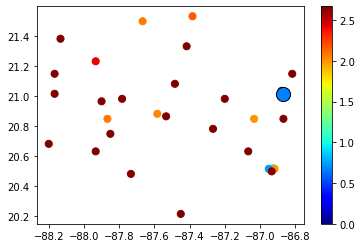

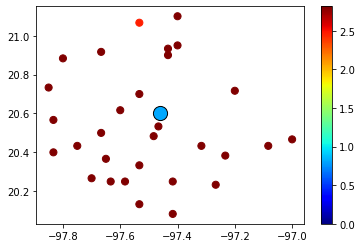

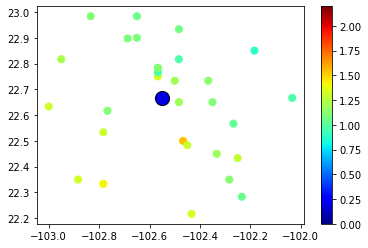

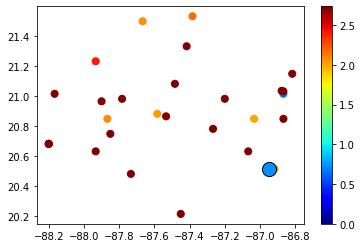

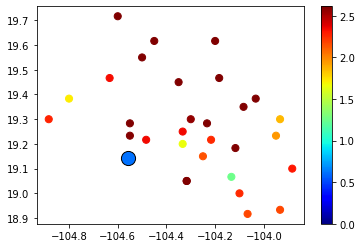

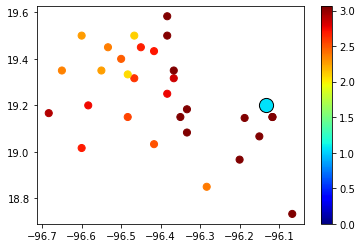

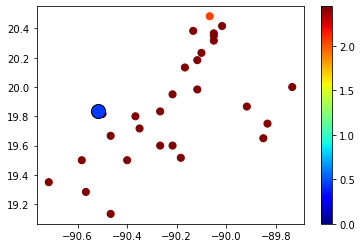

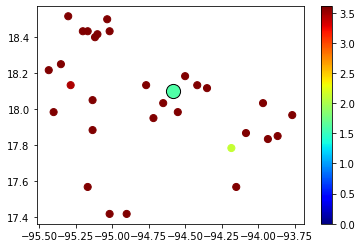

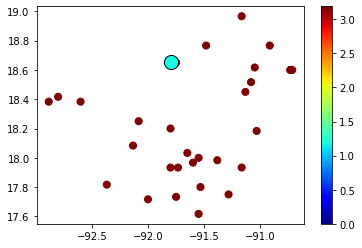

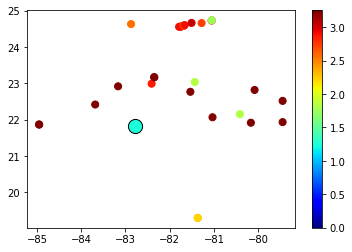

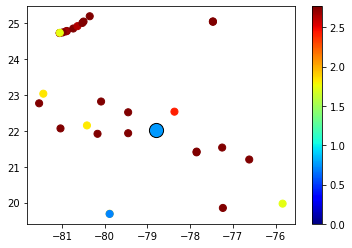

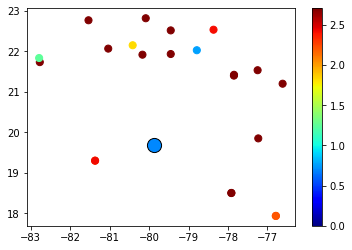

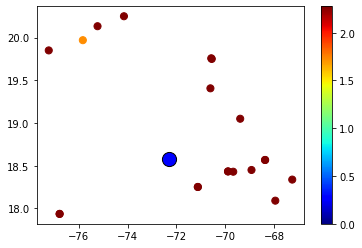

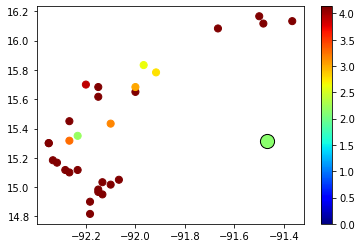

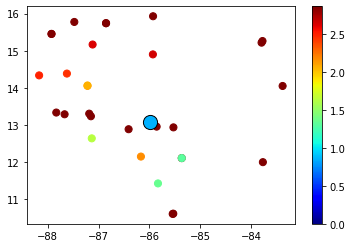

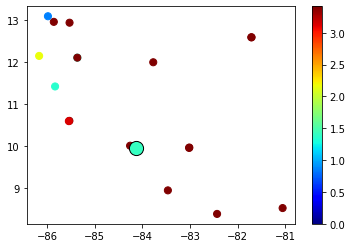

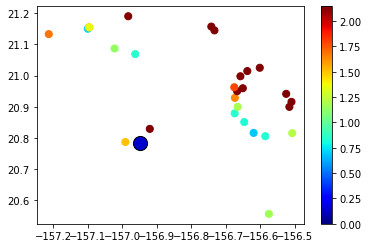

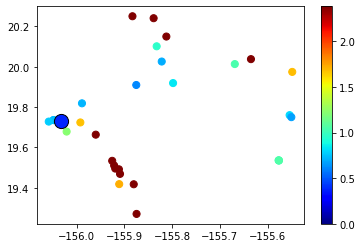

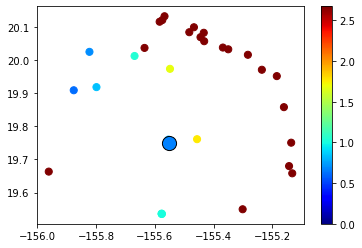

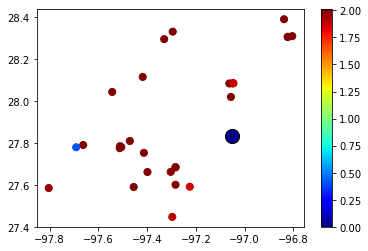

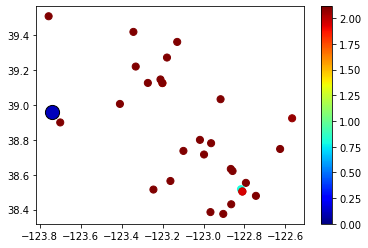

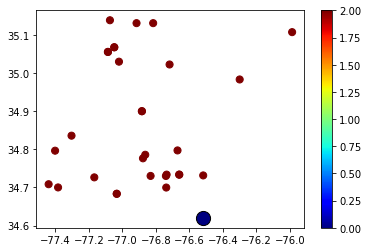

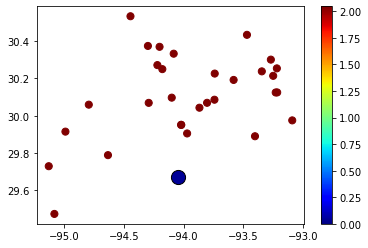

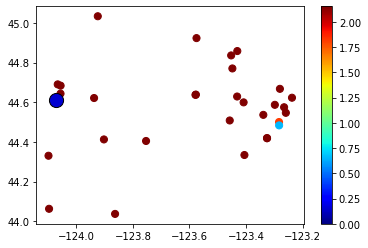

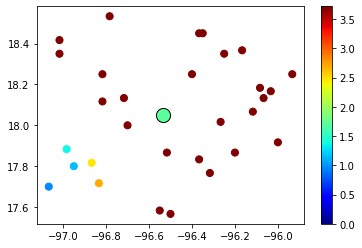

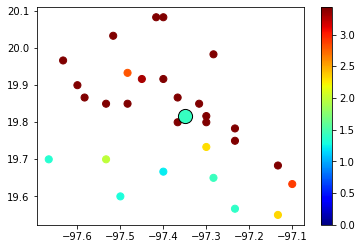

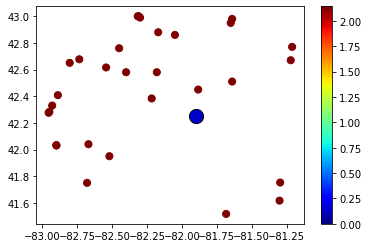

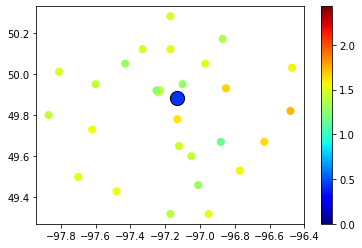

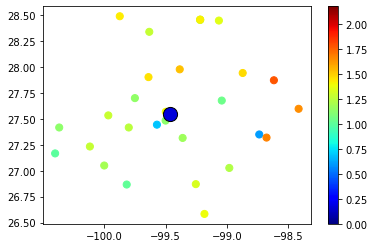

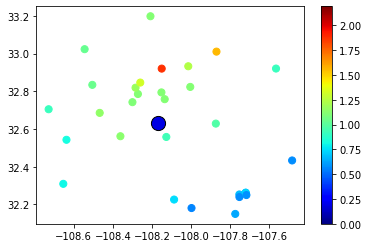

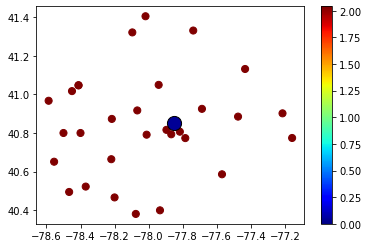

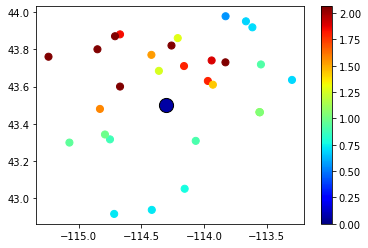

In [114]:
for i in range(len(ind_toxic1)):
    itar=ind_toxic1[i]
    inear=nearloc[itar]
    inear=inear[inear>-1]
#     print('tar stn',dstnm[itar])
#     print('tar reg',dregm[itar])
#     print('near stn',dstnm[inear])
    clim1=0
    clim2=dstnm[itar]+2
    plt.scatter(stn_lle[inear,1],stn_lle[inear,0],50,dstnm[inear],cmap='jet')
    plt.clim([clim1,clim2])
    plt.scatter(stn_lle[itar,1],stn_lle[itar,0],200,dstnm[itar],cmap='jet',edgecolors=[0,0,0])
    plt.clim([clim1,clim2])
    plt.colorbar()
    plt.show()

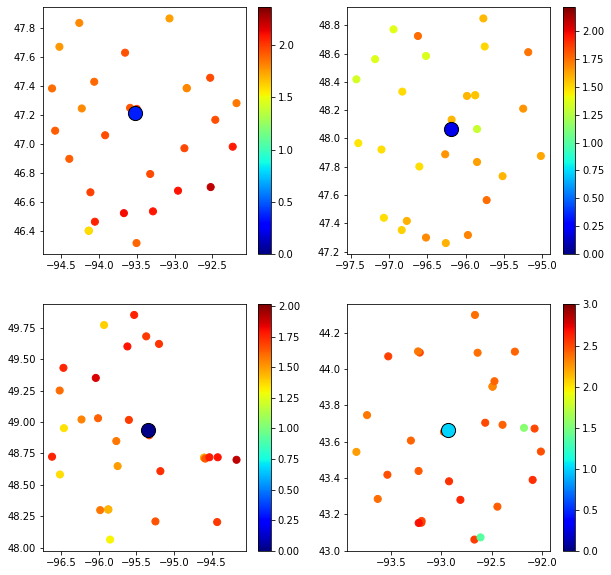

In [187]:
plt.figure(figsize=[10,10])
flag=1
for i in range(310,314):
    plt.subplot(2,2,flag)
    flag=flag+1
    itar=ind_toxic1[i]
    inear=nearloc[itar]
    inear=inear[inear>-1]
    clim1=0
    clim2=dstnm[itar]+2
    plt.scatter(stn_lle[inear,1],stn_lle[inear,0],50,dstnm[inear],cmap='jet')
    plt.clim([clim1,clim2])
    plt.scatter(stn_lle[itar,1],stn_lle[itar,0],200,dstnm[itar],cmap='jet',edgecolors=[0,0,0])
    plt.clim([clim1,clim2])
    plt.colorbar()

# Spatial distribution after removing toxic stations

Text(0.5, 1.0, 'Toxic stations')

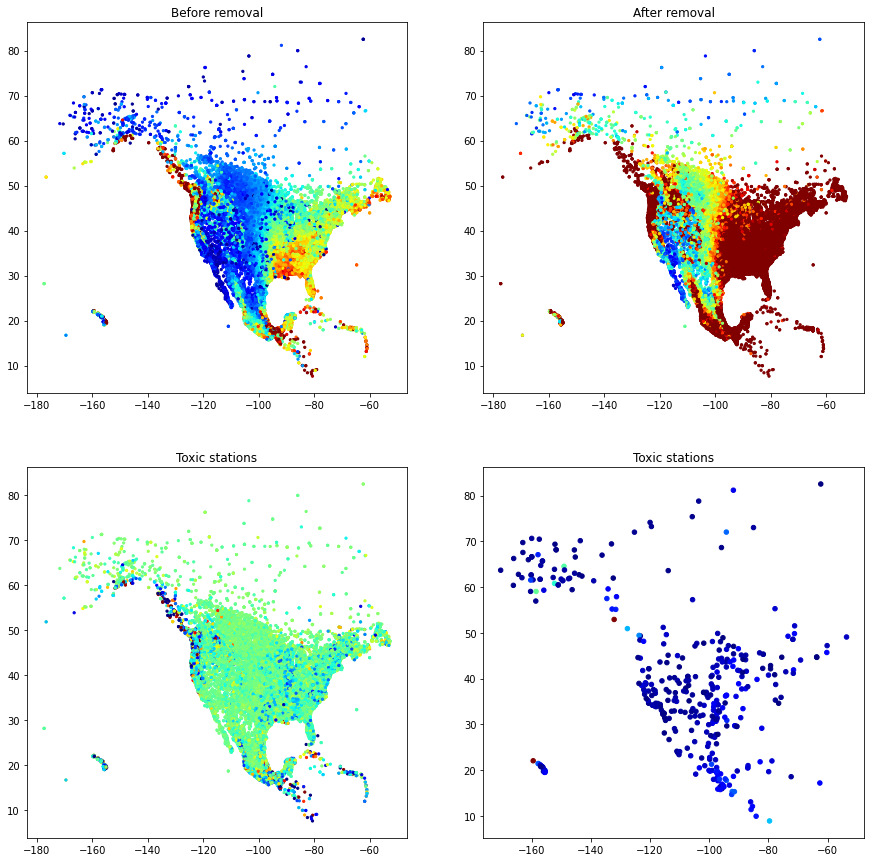

In [189]:
plt.figure(figsize=[15,15])

plt.subplot(2,2,1)
plt.scatter(stn_lle[:,1],stn_lle[:,0],5,dstnm,cmap='jet')
plt.clim([0,5])
plt.title('Before removal')

plt.subplot(2,2,2)
dinput=dstnm.copy()
dinput[ind_toxic1]=np.nan
plt.scatter(stn_lle[:,1],stn_lle[:,0],5,dinput,cmap='jet')
plt.clim([0,5])
plt.title('After removal')

plt.subplot(2,2,3)
plt.scatter(stn_lle[:,1],stn_lle[:,0],5,dinput-dregm,cmap='jet')
plt.clim([-2,2])
plt.title('Toxic stations')

plt.subplot(2,2,4)
plt.scatter(stn_lle[ind_toxic1,1],stn_lle[ind_toxic1,0],20,dstnm[ind_toxic1],cmap='jet')
plt.clim([0,10])
plt.title('Toxic stations')

In [136]:
from scipy import io
io.savemat('test.mat',{'dinput':dinput,'dstnm':dstnm,'stnlle':stn_lle})

In [165]:
ind1=np.where((stn_lle[:,1]>-100)&(stn_lle[:,1]<-98)&(stn_lle[:,0]>34)&(stn_lle[:,0]<37))[0]
min(dinput[ind1])

1.0526391

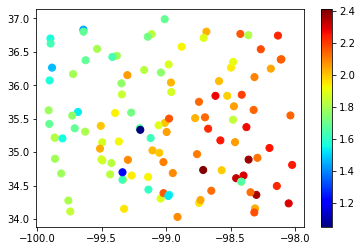

In [147]:
plt.scatter(stn_lle[ind1,1],stn_lle[ind1,0],50,dinput[ind1],cmap='jet')
plt.colorbar()

In [162]:
print(ratio_near[24628])
print(ratio[24628])

[0.05015354 0.05935676]
[0.05791801 0.05436975]


In [178]:
(np.arange(10)/0.1).astype(int)

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])